In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "bomb.png", width=600)

In [2]:
import pandas as pd
from bs4 import BeautifulSoup as BS
from urllib.request import urlretrieve, urlopen, Request
import numpy as np
import requests

from IPython import display
from ipywidgets import widgets
from IPython.display import display, clear_output

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'
r = requests.get(url)
html_doc = r.text
soup = BS(html_doc, 'html.parser')
for table in soup.find_all('table'):
    print (table.get('class')) ##sortable wikitable is the table class we want to access

['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-multiple_issues', 'compact-ambox']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Refimprove']
['plainlinks', 'metadata', 'ambox', 'ambox-style', 'ambox-Cleanup']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Update']
['plainlinks', 'metadata', 'ambox', 'ambox-content']
['sortable', 'wikitable']


In [4]:
trs = table.find_all('tr')

header = trs.pop(0)
ths = header.find_all('th')

headers = [x.text for x in ths]
data = []

for row in trs:
    tds = row.find_all('td')
    data.append([f.text for f in tds])
    
soup_df = pd.DataFrame.from_records(data, columns=headers)

Found the table class to reference: table class="sortable wikitable

In [5]:
quakes = pd.read_html(str(table),header=0)[0]
quakes.columns.values[1]= 'Country'
quakes['year'] = quakes['Origin (UTC)'].str[:4]

### strip characters
> alpha characters from Magnitude

> question marks from Lat, Long, Depth

> footnotes from Other Source and EM-DAT Deaths

In [6]:
pattern = r'\(.*\)|\[.*\]|\D'
quakes['Other Source Deaths'] = quakes['Other Source Deaths'].str.replace(pattern,"")
quakes['EM-DAT Total Deaths'] = quakes['EM-DAT Total Deaths'].str.replace(pattern,"")

mag_pattern = r'[^\.\d].*'
quakes['Magnitude'] = quakes['Magnitude'].str.replace(mag_pattern, "")

quakes['Other Source Deaths'] = pd.to_numeric(quakes['Other Source Deaths'])
quakes['EM-DAT Total Deaths'] = pd.to_numeric(quakes['EM-DAT Total Deaths'])
quakes['Magnitude'] = pd.to_numeric(quakes['Magnitude'])

lat_pattern = r'\?'
quakes['Lat'] = quakes['Lat'].replace(lat_pattern, np.nan, regex=True)
quakes['Long'] = quakes['Long'].replace(lat_pattern, np.nan, regex=True)
quakes['Depth (km)'] = quakes['Depth (km)'].replace(lat_pattern, np.nan, regex=True)
quakes['Lat'] = pd.to_numeric(quakes['Lat'])
quakes['Long'] = pd.to_numeric(quakes['Long'])
quakes['Depth (km)'] = pd.to_numeric(quakes['Depth (km)'])

quakes['Deaths'] = quakes[['PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']].max(axis=1)

#quakes['Country']
country_pattern = r'(, ?| ?\().*'
quakes['Country'] = quakes['Country'].str.replace(country_pattern, "")

### Start GeoPandas work. Convert to Points. Map to Coordinate Reference System

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# once cleaned Lat Long columns, ref http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
def make_point(row):
    return Point(row.Long, row.Lat)

points = quakes.apply(make_point, axis=1)
quakes = gpd.GeoDataFrame(quakes, geometry=points)

quakes.crs = {'init': 'epsg:4326'}

### import toolkits to control colorbar / plot axes. Map geopandas dataframe on world.plot, create ipywidgets M for magnitude floatSlider and D for country Dropdown

A Jupyter Widget

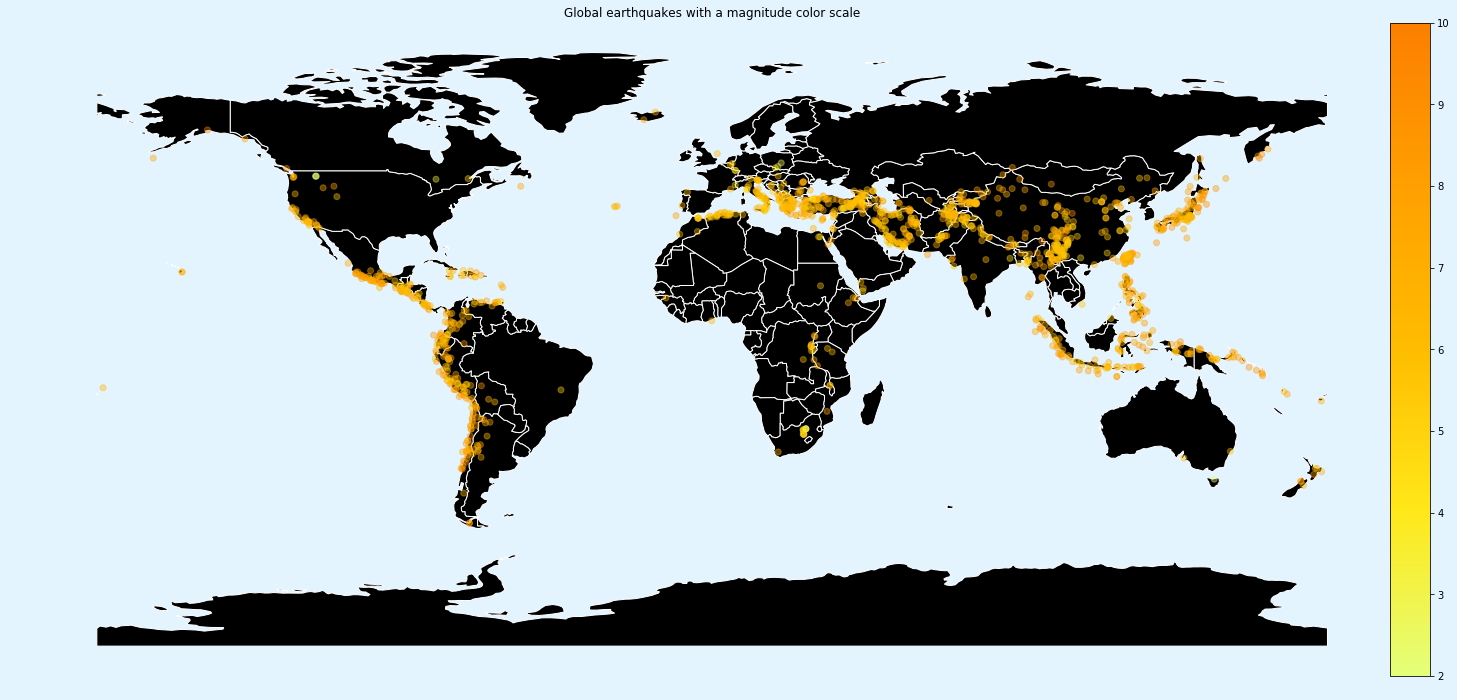

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable #imported for colorbar placement
import warnings

ax = world.plot(color='black', edgecolor='white', figsize=(25,55))   #world map background
ax.axis('off')
quakes.plot(ax=ax, column='Magnitude', alpha=0.4, cmap='Wistia');   #earthquake data, plotted on world map
plt.title('Global earthquakes with a magnitude color scale')
fig = ax.get_figure()
fig.patch.set_facecolor('#e4f4ff')   #blue water
divider = make_axes_locatable(ax)    #begins colorbar settings
cax = divider.append_axes('right', size='3%', pad=0.01)
sm = plt.cm.ScalarMappable(cmap='Wistia', norm=plt.Normalize(vmin=2.0, vmax=10.0))
sm._A = []
fig.colorbar(sm,cax=cax)

country = 'ALL'
minimum = 2.0
maximum = 9.5
world_copy = world.copy()

m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=quakes['Magnitude'].min(),
    max=quakes['Magnitude'].max(),
    description='Magnitude',
    continuous_update=False,
)

countries = sorted(list(set(quakes.Country)))
countries.insert(0, 'ALL')
countries.remove("")

d = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)

z = widgets.HBox([m,d])
display(z)

def response(change):
    try:
        clear_output(wait=True)     #prevents repeating graphs. Clears output then replots
        global country
        global maximum
        global minimum
        global world_copy
        if len(change['new']) == 2:
            maximum = change['new'][1]
            minimum = change['new'][0]
        else:
            country = change['new']
        display(z)
        if country.upper() == 'ALL':
            display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes['Magnitude'] <= maximum)]
            world_copy = world
        else:
            display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes['Magnitude'] <= maximum) & (quakes['Country'].str.upper() == country.upper())]
            world_copy = world[world['name'].str.upper() == country.upper()]
        
#replotting maps based on widget changes
#adjust colormap scale to reflect new min/max. 
        ax = world_copy.plot(color='black', edgecolor='white', figsize=(25,55))
        ax.axis('off')
        plt.title('Global earthquakes with a magnitude color scale')
        display_df.plot(ax=ax, column='Magnitude', alpha=0.7, cmap='Wistia');
        fig = ax.get_figure()
        fig.patch.set_facecolor('#e4f4ff')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.01)
        sm = plt.cm.ScalarMappable(cmap='Wistia', norm=plt.Normalize(vmin=minimum, vmax=maximum)) 
        sm._A = []
        fig.colorbar(sm,cax=cax)
    except:
        print("There are no earthquakes of this magnitude range in the country specified. Try again")
        warnings.filterwarnings('ignore')
            
m.observe(response, names='value')
d.observe(response, names='value')

A Jupyter Widget

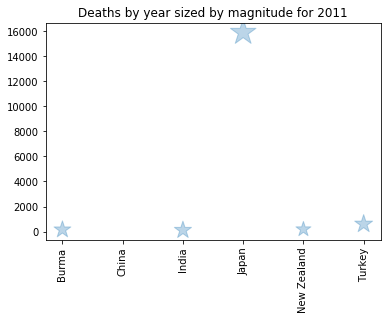

      year      Country  Magnitude   Deaths
1336  2011        Burma        6.8    150.0
1334  2011        China        5.4      NaN
1338  2011        India        6.9    111.0
1335  2011        Japan        9.0  15894.0
1337  2011        Japan        7.1      NaN
1333  2011  New Zealand        6.3    181.0
1339  2011       Turkey        7.1    601.0


In [9]:
plot_year_death = quakes.copy() #copy the original df and rename for this specific plot
years = sorted(list(set(plot_year_death['year']))) #make unique list of years, ascending
plot_year_death = plot_year_death.loc[plot_year_death['year']==years[-1]] #years[-1] chooses most recent year for display

plt.title('Deaths by year sized by magnitude for ' + years[-1]) #display year selection in title
plt.xticks(rotation='vertical')
plt.scatter(plot_year_death['Country'], plot_year_death['Deaths'], marker='*', alpha=0.3, s=plot_year_death['Magnitude']**3, )

d_y = widgets.Dropdown(
    options=years,
    value=years[-1],  # using -1 defaults to the most recent year of unique years list
    description='Year',
    disabled=False,
)
display(d_y)
plt.show()
print(plot_year_death[['year','Country','Magnitude','Deaths']].sort_values('Country'))

def plot_y(y_change):
    clear_output()
    year = y_change['new']
    plot_year_death = quakes.copy() 
    plot_year_death = plot_year_death.loc[plot_year_death['year']==year] #new df with year selected
    display(d_y)
    plt.title('Deaths by country sized by magnitude for ' + year) #display year selection in title
    plt.xticks(rotation='vertical')
    plt.scatter(plot_year_death['Country'], plot_year_death['Deaths'], marker='*', alpha=0.3, s=plot_year_death['Magnitude']**3)
    plt.show()
    print(plot_year_death[['year','Country','Magnitude','Deaths']].sort_values('Country'))
    # printing supporting data for additional insight

d_y.observe(plot_y, names='value')
#2007

A Jupyter Widget

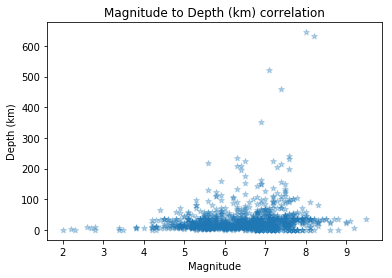

In [10]:
mag_dep = quakes.groupby(['Country','Magnitude','Depth (km)'])['Deaths'].sum()
mag_dep=mag_dep.reset_index()
mag_dep
plt.title('Magnitude to Depth (km) correlation')
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')
plt.scatter(mag_dep['Magnitude'],mag_dep['Depth (km)'], marker='*', alpha=0.3)

d_c = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)
display(d_c)

def plot_d(c_change):
    clear_output()
    country = c_change['new']
    plot_mag_dep = mag_dep.loc[mag_dep['Country']==country]
    display(d_c)
    plt.title('Magnitude to Depth (km) correlation for ' + country)
    plt.xlabel('Magnitude')
    plt.ylabel('Depth (km)')
    plt.scatter(plot_mag_dep['Magnitude'],plot_mag_dep['Depth (km)'], marker='*', alpha=0.3)

d_c.observe(plot_d, names='value')
#use China or Japan for testing

A Jupyter Widget

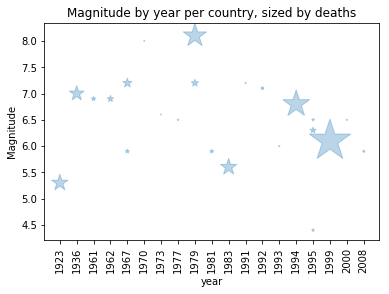

In [11]:
c_y_d = quakes.groupby(['Country','year','Magnitude'])['Deaths'].sum()
c_y_d=c_y_d.reset_index()
countries.remove('ALL')
c_y_d_select = c_y_d.loc[c_y_d['Country']=='Colombia']

plt.title('Magnitude by year per country, sized by deaths')
plt.xlabel('year')
plt.xticks(rotation='vertical')
plt.ylabel('Magnitude')
plt.scatter(c_y_d_select['year'],c_y_d_select['Magnitude'], marker='*', alpha=0.3, s=c_y_d_select['Deaths'])

d_y_d = widgets.Dropdown(
    options=countries,
    value='Colombia',
    description='Country',
    disabled=False,
)
display(d_y_d)

def plot_c_y_d(c_y_d_change):
    clear_output()
    country = c_y_d_change['new']
    c_y_d_select = c_y_d.loc[c_y_d['Country']==country]
    display(d_y_d)
    plt.title('Magnitude by year for ' + country + ' sized by deaths')
    plt.xlabel('year')
    plt.xticks(rotation='vertical')
    plt.ylabel('Magnitude')
    plt.scatter(c_y_d_select['year'],c_y_d_select['Magnitude'], marker='*', alpha=0.3, s=c_y_d_select['Deaths'])

d_y_d.observe(plot_c_y_d, names='value')
#colombia for testing

A Jupyter Widget

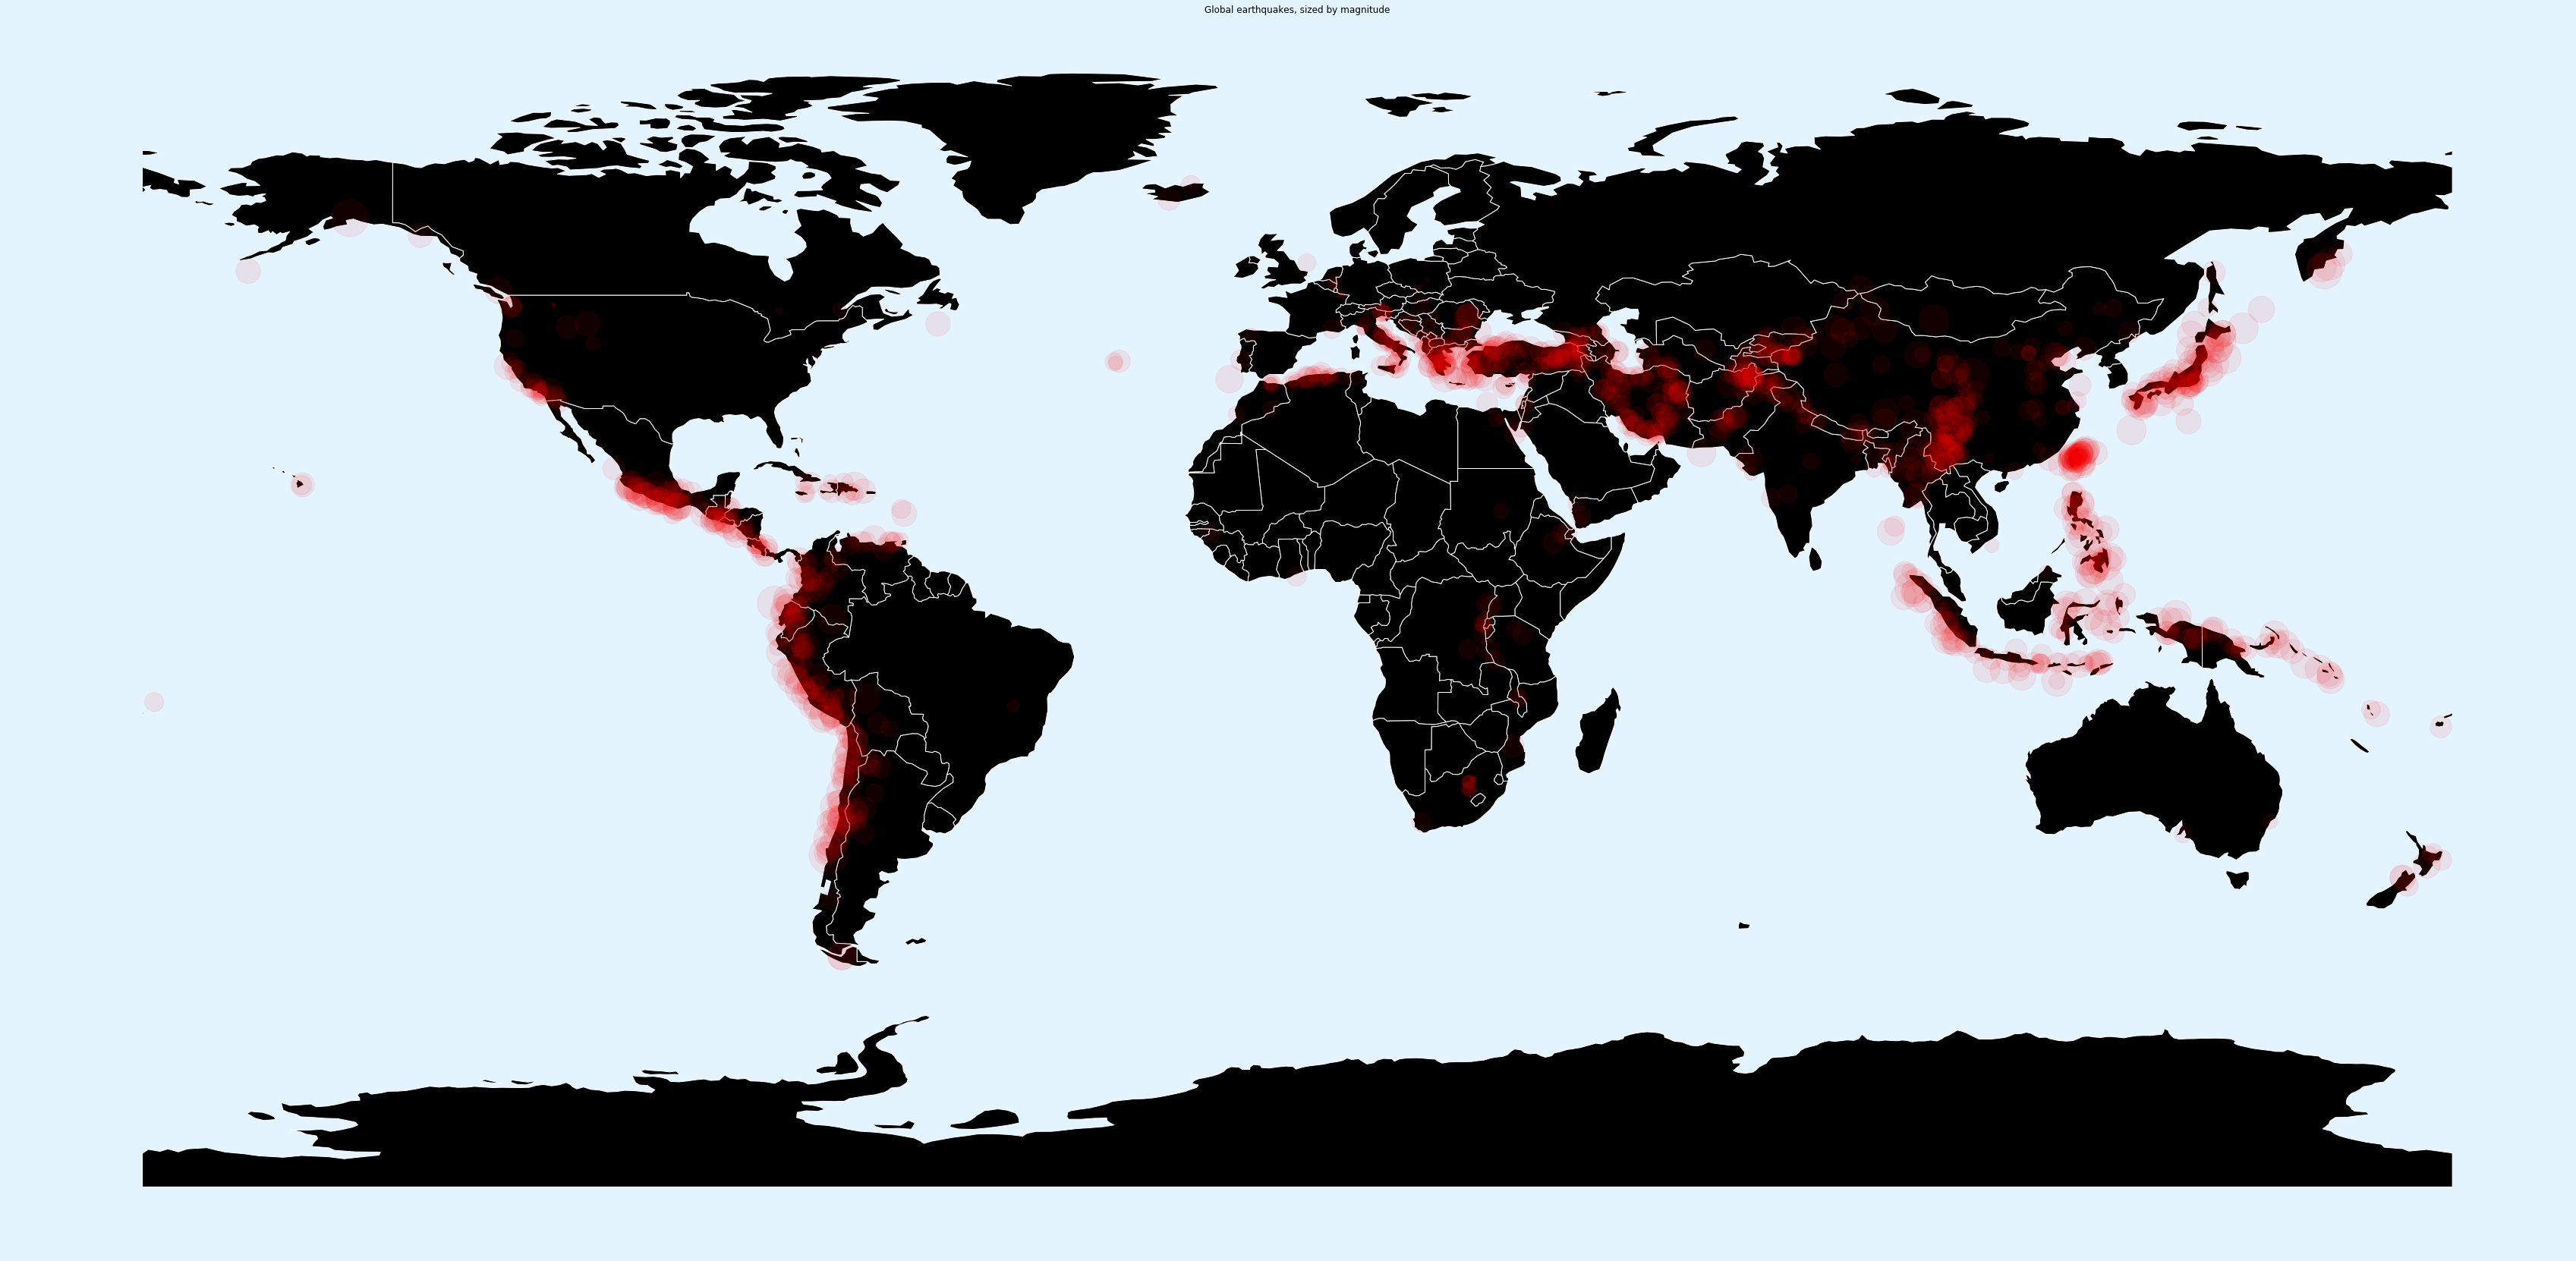

In [12]:
# scatter plot for size by magnitude
from mpl_toolkits.axes_grid1 import make_axes_locatable #imported for colorbar placement
#import traitlets
import warnings

## repeated below to re-display graph ##
ax = world.plot(color='black', edgecolor='white', figsize=(60,120))
ax.axis('off')
plt.title('Global earthquakes, sized by magnitude')
plt.scatter(x=quakes['Long'], y=quakes['Lat'], s=quakes['Magnitude']**3.5, alpha=0.08, c='red');
fig = ax.get_figure()
fig.patch.set_facecolor('#e4f4ff')
## repeated below to re-display graph ##

country = 'ALL'
minimum = 2.0
maximum = 9.5
world_copy = world.copy()

m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=quakes['Magnitude'].min(),
    max=quakes['Magnitude'].max(),
    description='Magnitude',
    continuous_update=False,
)

countries = sorted(list(set(quakes.Country)))
countries.insert(0, 'ALL')
countries.remove("")

d = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)
z = widgets.HBox([m,d])
display(z)

def response(change):
    try:
        clear_output(wait=True)
        global country
        global maximum
        global minimum
        global world_copy
        if len(change['new']) == 2:
            maximum = change['new'][1]
            minimum = change['new'][0]
        else:
            country = change['new']
        display(z)
        if country.upper() == 'ALL':
            display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes['Magnitude'] <= maximum)]
            world_copy = world
        else:
            display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes['Magnitude'] <= maximum) & (quakes['Country'].str.upper() == country.upper())]
            world_copy = world[world['name'].str.upper() == country.upper()]

        ax = world_copy.plot(color='black', edgecolor='white', figsize=(25,55))
        ax.axis('off')
        plt.scatter(x=display_df['Long'], y=display_df['Lat'], s=display_df['Magnitude']**3.5, alpha=0.5, c='yellow');
        plt.title('Global earthquakes, sized by magnitude')
        plt.show()
        print(display_df['Lat','Long','Magnitude'])
        fig = ax.get_figure()
        fig.patch.set_facecolor('#e4f4ff')
    except:
        print("Ain't no earthquakes of this magnitude in this country... Try again")
        warnings.filterwarnings('ignore')


m.observe(response, names='value')
d.observe(response, names='value')

In [13]:
#importing json file for tectonic plates
import json
fname = "PB2002_steps.json"
boundaries = gpd.read_file(fname)

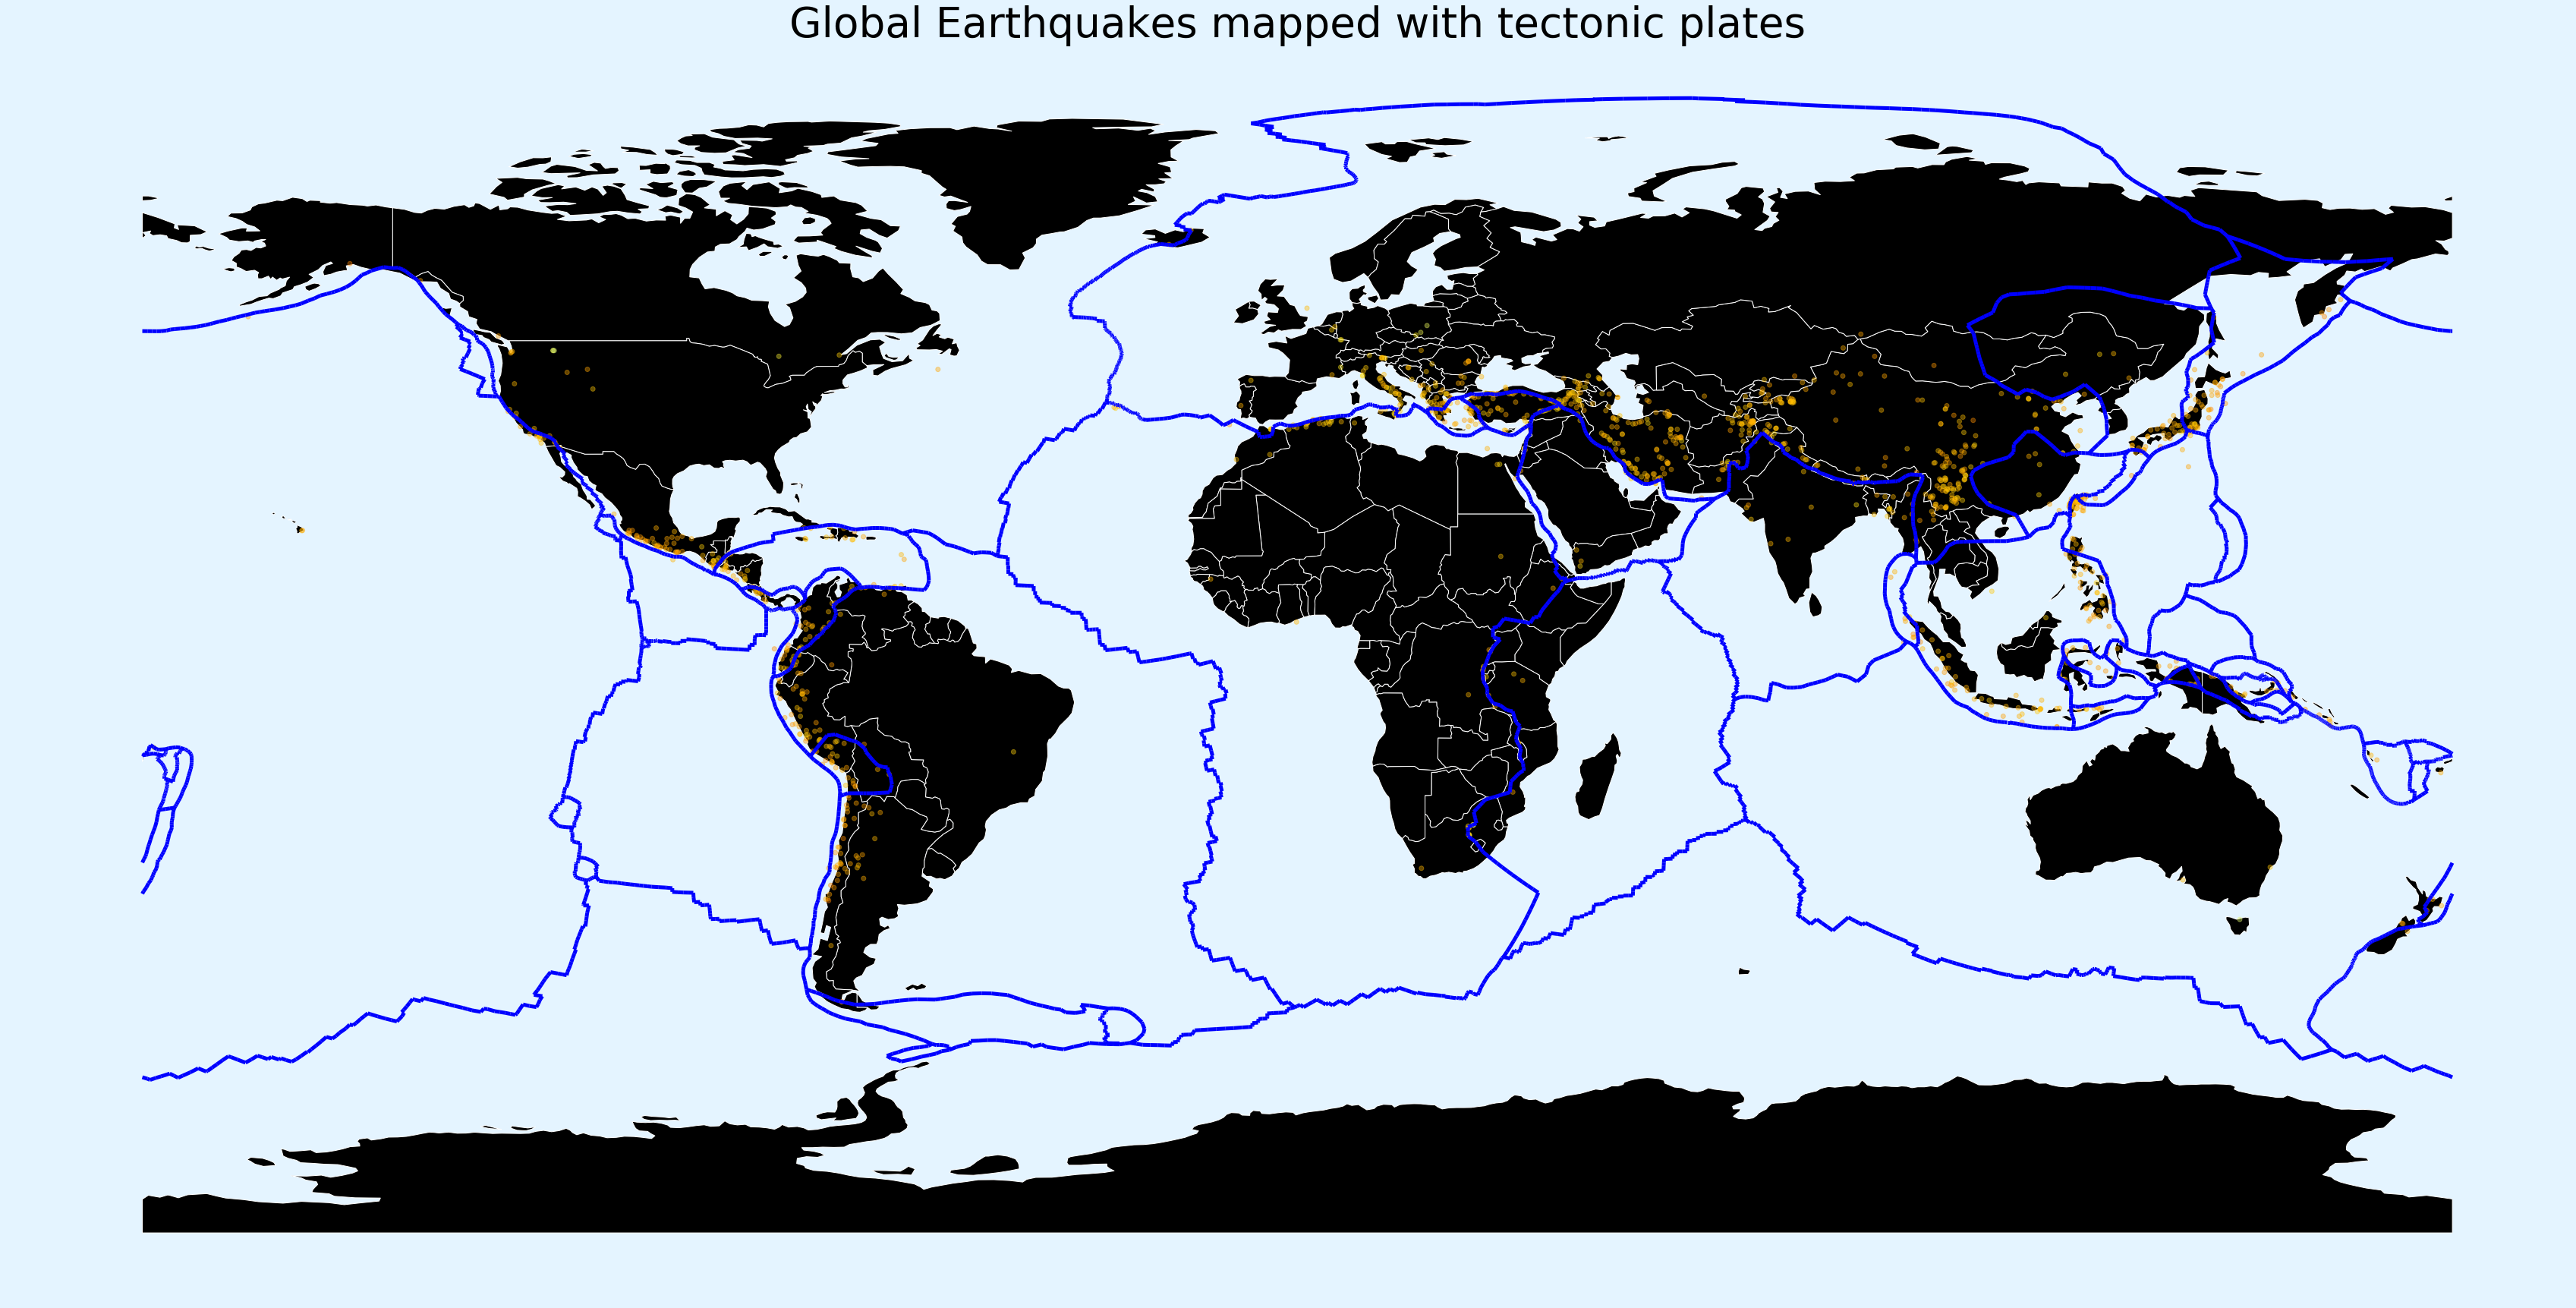

In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

def make_point(row):
    return Point(row.Long, row.Lat)

points = quakes.apply(make_point, axis=1)
quakes = gpd.GeoDataFrame(quakes, geometry=points)
ax = world.plot(color='black', edgecolor='white', figsize=(60,120))
ax.axis('off')
quakes.plot(ax=ax, column='Magnitude', alpha=0.4, cmap='Wistia');
fig = ax.get_figure()
fig.patch.set_facecolor('#e4f4ff')
plt.title('Global Earthquakes mapped with tectonic plates', size=55)
boundaries.plot(ax=ax, color='blue', linewidth=5);

In [15]:
import folium
new_map = folium.Map(location=[43.1,40.3], zoom_start=2)

for row in quakes.iterrows():
    row = list(row[1])
    try:
        folium.Marker([row[2],row[3]], popup=str(row[1]) + ' | ' + str(row[0]) + ' | Magnitude: ' + str(row[5])).add_to(new_map)
    except:
        continue
new_map